<a href="https://colab.research.google.com/github/yufanwang2008/molecular_dynamics/blob/main/Amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("mamba install -c conda-forge ambertools -y", shell=True)
import pytraj as pt
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("mamba install openmm", shell=True)
subprocess.run("pip install --upgrade MDAnalysis", shell=True)

#load dependencies
import sys
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
import subprocess

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 17 21:57:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             29W /   70W |     202MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#@title **From SDF to RMSD**
# STEP 1: Setup
compound_id = '' #@param {type:"string"}
sdf_file = f"/content/drive/MyDrive/molecular_dynamics/{compound_id}.sdf"
workDir = "/content/drive/MyDrive/molecular_dynamics"
os.makedirs(workDir, exist_ok=True)

# STEP 2: AmberTools setup
!conda install -y -c conda-forge ambertools > /dev/null

# STEP 3: Convert SDF to mol2 and frcmod
!cp {sdf_file} /content/
!antechamber -i {compound_id}.sdf -fi sdf -o {compound_id}.mol2 -fo mol2 -c bcc -s 2 -at gaff -nc 0 -m 1
!parmchk2 -i {compound_id}.mol2 -f mol2 -o {compound_id}.frcmod

# STEP 4: Solvate with tleap
tleap_input = f"""
source leaprc.gaff2
source leaprc.water.tip3p

MOL = loadmol2 "{compound_id}.mol2"
loadamberparams "{compound_id}.frcmod"

solvatebox MOL TIP3PBOX 12.0

saveamberparm MOL {compound_id}_solvated.prmtop {compound_id}_solvated.inpcrd
savepdb MOL {compound_id}_solvated.pdb
quit
"""
with open("tleap.in", "w") as f: f.write(tleap_input)
!tleap -f tleap.in > tleap.log
!mv {compound_id}_* {workDir}/

# STEP 5: Equilibration MD (short NPT)
from openmm.app import *
from openmm import *
from openmm.unit import *
import os

# Load parameters
Jobname = f"{compound_id}_equil"
prmtop = AmberPrmtopFile(f"{workDir}/{compound_id}_solvated.prmtop")
inpcrd = AmberInpcrdFile(f"{workDir}/{compound_id}_solvated.inpcrd")

system = prmtop.createSystem(
    nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer,
    constraints=HBonds, rigidWater=True, ewaldErrorTolerance=0.0005)
system.addForce(MonteCarloBarostat(1*bar, 310*kelvin))

integrator = LangevinIntegrator(310*kelvin, 1.0, 2*femtoseconds)
integrator.setConstraintTolerance(0.000001)
temperature = 310 * kelvin          # or whatever temperature you're using
dt = 2 * femtoseconds               # or whatever timestep you want

prod_integrator = LangevinIntegrator(temperature, 1.0, dt)
prod_integrator.setConstraintTolerance(0.000001)

simulation = Simulation(prmtop.topology, system, prod_integrator)

simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors: simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("⚡ Minimizing...")
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(310*kelvin)

# Output files
dcd_file = f"{workDir}/{Jobname}.dcd"
log_file = f"{workDir}/{Jobname}.log"
rst_file = f"{workDir}/{Jobname}.rst"
pdb_out = f"{workDir}/{Jobname}.pdb"

simulation.reporters.append(DCDReporter(dcd_file, 100))
simulation.reporters.append(StateDataReporter(log_file, 100, step=True, temperature=True, potentialEnergy=True))
simulation.step(10000)  # ~20 ps

state = simulation.context.getState(getPositions=True, getVelocities=True)
with open(rst_file, 'w') as f: f.write(XmlSerializer.serialize(state))
PDBFile.writeFile(simulation.topology, state.getPositions(), open(pdb_out, 'w'))

# STEP 6: Production MD (2 ns)
Jobname = f"{compound_id}_prod"
prmtop = AmberPrmtopFile(f"{workDir}/{compound_id}_solvated.prmtop")
inpcrd = AmberInpcrdFile(f"{workDir}/{compound_id}_solvated.inpcrd")
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

with open(f"{workDir}/{compound_id}_equil.rst", 'r') as f:
    simulation.context.setState(XmlSerializer.deserialize(f.read()))

# Output
dcd_file = f"{workDir}/{Jobname}_1.dcd"
log_file = f"{workDir}/{Jobname}_1.log"
rst_file = f"{workDir}/{Jobname}_1.rst"
pdb_out = f"{workDir}/{Jobname}_1.pdb"

simulation.reporters.clear()
simulation.reporters.append(DCDReporter(dcd_file, 500))
simulation.reporters.append(StateDataReporter(log_file, 500, step=True, temperature=True, potentialEnergy=True))
simulation.step(1000000)  # 2 ns

state = simulation.context.getState(getPositions=True, getVelocities=True)
with open(rst_file, 'w') as f: f.write(XmlSerializer.serialize(state))
PDBFile.writeFile(simulation.topology, state.getPositions(), open(pdb_out, 'w'))

# STEP 7: Strip waters + align trajectory
import MDAnalysis as mda
from MDAnalysis.analysis import align
import pytraj as pt

pdb = f"{workDir}/{compound_id}_equil.pdb"
traj = f"{workDir}/{compound_id}_prod_1.dcd"
u = mda.Universe(pdb, traj)
ref = mda.Universe(pdb)

align.AlignTraj(u, ref, select='all', in_memory=True).run()
stripped = u.select_atoms("not resname HOH")

nw_dcd = f"{workDir}/{compound_id}_prod_1-1_nw.dcd"
nw_pdb = f"{workDir}/{compound_id}_prod_nw.pdb"
with mda.Writer(nw_dcd, stripped.n_atoms) as W:
    for ts in u.trajectory:
        W.write(stripped)
stripped.write(nw_pdb)

# STEP 8: Compute RMSD (heavy atoms only)
from MDAnalysis.analysis import rms

u = mda.Universe(nw_pdb, nw_dcd)
ref = mda.Universe(nw_pdb)

mobile_atoms = u.select_atoms("not name H*")
reference_atoms = ref.select_atoms("not name H*")

R = rms.RMSD(mobile_atoms, reference_atoms).run()
rmsd = R.rmsd[:, 2]  # RMSD column in Å

print("✅ RMSD array ready! Shape:", rmsd.shape)




==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda


Info: acdoctor mode is on: check and diagnose problems in the input file.
Info: The atom type is set to gaff; the options available to the -at flag are
      gaff, gaff2, amber, bcc, abcg2, and sybyl.

-- Check Format for sdf File --
   Status: pass
Info: Determining atomic numbers from atomic symbols which are case sensitive.
Running: /usr/local/bin/bondtype -j full -i ANTECHAMBER_BOND_TYPE.AC0 -o ANTECHAMBER_BOND_TYPE.AC -f ac

Running: /usr/local/bin/atomtype -i ANTECHAMBER_AC.AC0 -o ANTECHAMBER_AC.AC -p gaff
Info: Total number of electrons: 302; net charge: 0

Running: /usr/local/bin/sqm -O -i sqm.in -o sqm.out

Running: /usr/local/bin/am1bcc -i ANTECHAMBER_AM1BCC_PRE.AC -o ANTECHAMBER_AM1BCC.AC -f ac -t bcc -p /usr/local/dat/antechamber/BCCPARM.DAT -s 2 -j 1

Running: /usr/local/bin/atomtype -

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


✅ RMSD array ready! Shape: (2000,)


/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


/tmp/ipython-input-12-3230664298.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)


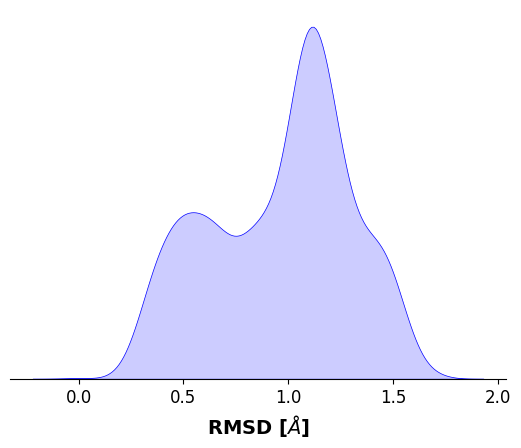

In [ ]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')